### Import libraries

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import root_mean_squared_error
from scipy.stats import spearmanr

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import seaborn as sns

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Helvetica'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

### Read the data

In [26]:
df = pd.read_parquet('../data/submissions.parquet')

### Train-Test Split

In [27]:
N = round(len(df)*.85)

# train - test split
train = df[df['train_valid_test'] != 'test']
test = df[df['train_valid_test'] == 'test']

## T to predict TA

### Train the model

In [28]:
lr = LinearRegression()

In [29]:
X_train = train['submission_openai'].to_numpy().reshape(-1, 1)
y_train = train['mean_openai'].to_numpy()

X_test = test['submission_openai'].to_numpy().reshape(-1, 1)
y_test = test['mean_openai'].to_numpy()

In [30]:
lr.fit(X_train, y_train)

LinearRegression()

### Predict

In [31]:
predictions = lr.predict(X_test)

### Evaluate

In [32]:
stats, pval = spearmanr(y_test, predictions)
print(f"Spearman Correlation={stats}, p-val={pval}")

Spearman Correlation=0.2618840257694901, p-val=0.0


In [33]:
print("RMSE Score:", root_mean_squared_error(y_test, predictions))

RMSE Score: 0.12827069689467124


### Visualize the TA - T relationsip

/tmp/ipykernel_193695/1094934490.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_joint.legend(frameon=False, loc='upper center')


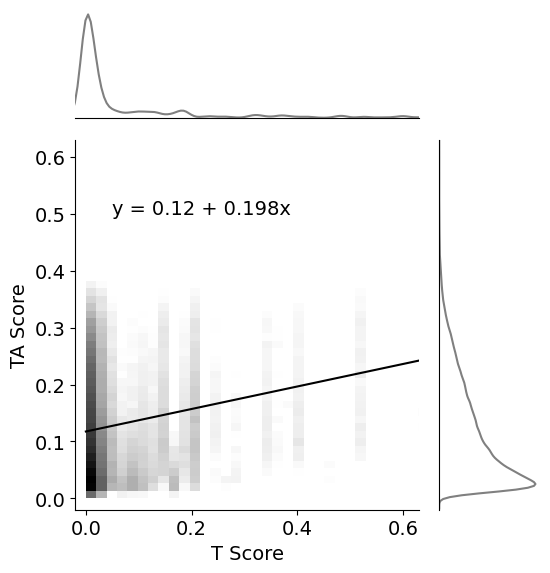

In [ ]:
fig = plt.figure(figsize=(6, 6.5))

gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

min_val, max_val = -.02, .63

for d in ['right', 'top']:
    ax_joint.spines[d].set_visible(False)

ax_joint.hist2d(test['submission_openai'], 
                test['ta_score'],
                cmap='Grays',
                bins=51,
                density=True,
                cmin=1,
                alpha=1,
                norm=LogNorm(),
                )

ax_joint.set_xlim(min_val, max_val)
ax_joint.set_ylim(min_val, max_val)

ax_joint.set_xlabel("T Score")
ax_joint.set_ylabel("TA Score")

ax_joint.legend(frameon=False, loc='upper center')


for score, ax in zip(['submission_openai', 'ta_score'], [ax_marg_x, ax_marg_y]):
    if score == 'submission_openai':
        sns.kdeplot(x=test[score], ax = ax, color='gray', bw_adjust=.7)
        ax.set_xlim(min_val, max_val+.05)
        for d in ['top', 'right', 'left']:
            ax_marg_x.spines[d].set_visible(False)
    else:
        sns.kdeplot(y=test[score], ax = ax, color='gray', bw_adjust=.7)
        ax.set_ylim(min_val, max_val+.05)
        for d in ['right', 'bottom', 'top']:
            ax_marg_y.spines[d].set_visible(False)

    # remove x-y ticks
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

    ax.set_xlabel("")
    ax.set_ylabel("")

ax_joint.plot([0, max_val],
        [lr.intercept_, lr.intercept_ + lr.coef_[0]*max_val], 
        color='black',
        #lw=1,
        label='Linear Fit')

eq = f'y = {round(lr.intercept_,2)} + {round(lr.coef_[0],3)}x'
ax_joint.text(.05, .5, eq)

fig.savefig('../figures/ta_vs_t.pdf')

fig.show()